In [88]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from advectionGP.constraints import NonNegConstraint
from advectionGP.sensors import FixedSensorModel 
from advectionGP.kernels import meshgridndim
from advectionGP.kernels import EQ 
from advectionGPdatasets.ode_modelsample import ODEModelSample
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as ODEModel
from scipy.stats import norm
def compute_nlpd(obs_samples,true_vals):
    nlpd = 0
    for idx in range(len(true_vals)):
        ob = np.array(obs_samples)[:,idx]
        nlpd-=norm.logpdf(true_vals[idx],np.mean(ob),np.std(ob))
    return nlpd

#v,plt.hist(ob,7)

#x = np.linspace(-25,35,100)
#plt.plot(x,100*norm.pdf(x,np.mean(ob),np.std(ob)))
#plt.vlines(Y[1::2][4],0,5)

# Generate Results

In [109]:
#results = []
for seed in range(20):
    np.random.seed(seed)
    ds = ODEModelSample(non_neg=True,k_0=-0.01,u=0.2,eta=0.1,ls=0.5,Npoints=10)
    X, Y, sourceGT, concTrain, boundary, m = ds.X, ds.Y, ds.source, ds.conc, ds.boundary, ds.m

    Nsamples = 50
    record = {}
    ls = 0.5


    np.random.seed(42)
    N_feat = 500 #Number of features used to infer the source
    k = EQ(ls, 2.0)
    res = [400]
    noiseSD = 0.1
    sensors = FixedSensorModel(X[::2],0.1)

    k_0=-0.01
    u=0.1
    eta=0.1

    mTest = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,k_0=k_0,u=u,eta=eta)
    regressors = mTest.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = mTest.computeZDistribution(Y[::2]) # Infers z vector mean and covariance


    concInferred_samples = []
    sourceInferred_samples = []
    sse_samples = []
    obs_samples = []

    mTest.sensormodel = FixedSensorModel(X[1::2],0.1)
    for jitterA in [0,1e-8,1e-7,1e-6,1e-5,1e-4,None]:
        if jitterA is None:
            break
        try:
            Zsamps = np.random.multivariate_normal(meanZ,covZ+np.eye(len(covZ))*jitterA,Nsamples)
            break
        except np.linalg.LinAlgError:
            print("Failed to invert during Non-negative sampling. Adding jitter...")


    #we just give up with this data point...
    if jitterA is None:
        print("Giving up with this configuration")


    for Z in Zsamps:
        sourceInferred = mTest.computeSourceFromPhi(Z) # Generates estimated source using inferred distributio
        sourceInferred_samples.append(sourceInferred)

        conc = mTest.computeResponse(sourceInferred)
        concInferred_samples.append(conc)
        mTest.conc = conc
        obs = mTest.computeObservations()
        #sse_samples.append(np.sum((obs-Y[1::2])**2))
        sse_samples.append(np.sum((np.mean(np.array(obs),0)-Y[1::2])**2))
        obs_samples.append(obs)

    ###Non-neg calculation...
    #################################################################################################
    mTest.sensormodel = FixedSensorModel(X[::2],0.1)
    concInferred_nonneg_samples = []
    sourceInferred_nonneg_samples = []
    sse_nonneg_samples = []
    obs_nonneg_samples = []

    for jitterB in [0,1e-8,1e-7,1e-6,1e-5,1e-4,None]:
        if jitterB is None:
            break
        try:
            nnc = NonNegConstraint(mTest,Y[::2],np.linspace(0,20,200)[:,None],thinning=3,burnin=20,jitter=jitterB,verbose=True)
            break
        except np.linalg.LinAlgError:
            print("Failed to invert during Non-negative sampling. Adding jitter...")

    if jitterB is None:
        print("Giving up with this configuration")


    try:
        samps = nnc.sample(Nsamples=Nsamples)
    except NoValidStartPointFoundError:
        print("NoValidStartPointFoundError!!")

    mTest.sensormodel = FixedSensorModel(X[1::2],0.1)
    for samp in samps:
        sourceInferred = mTest.computeSourceFromPhi(samp)
        sourceInferred_nonneg_samples.append(sourceInferred)

        conc = mTest.computeResponse(sourceInferred)
        concInferred_nonneg_samples.append(conc)
        mTest.conc = conc
        obs = mTest.computeObservations()
        #sse_nonneg_samples.append(np.sum((obs-Y[1::2])**2))
        sse_nonneg_samples.append(np.sum((np.mean(np.array(obs),0)-Y[1::2])**2))
        obs_nonneg_samples.append(obs)

    
    #record[u]=[mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples]
    rec =[mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples]
    #pickle.dump(record,open('recordODEfindparams_u_%d_seed=%d.pkl' % (it,seed),'wb'))
    
    sse_nonneg = np.sum((np.mean(np.array(obs_nonneg_samples),0)-Y[1::2])**2)
    sse_normal = np.sum((np.mean(np.array(obs_samples),0)-Y[1::2])**2)
    
    results.append([sse_normal,sse_nonneg, compute_nlpd(obs_samples,Y[1::2]), compute_nlpd(obs_nonneg_samples,Y[1::2])])



Computing mean and covariance of Z distribution
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
   21/   22 [samples]


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
  169/  170 [samples]


Computing mean and covariance of Z distribution
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
   21/   22 [samples]


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z 

In [114]:
print("sse_normal, sse_nonneg, nlpd_normal, nlpd_nonneg")
np.mean(np.array(results),0),1.96*np.std(np.array(results),0)/np.sqrt(20)


sse_normal, sse_nonneg, nlpd_normal, nlpd_nonneg


(array([264.52367,  81.53325,  17.07234,  14.52693]),
 array([51.3608 , 16.18542,  0.30254,  0.32533]))

95.0


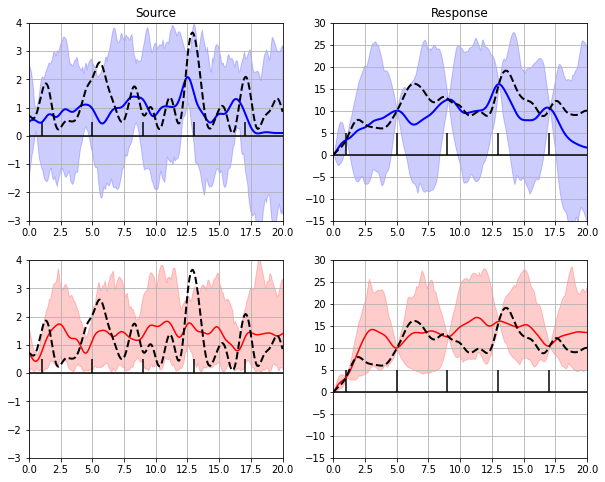

In [133]:
#CIs = [16,84]
CIs = [2.5,97.5]
print(CIs[1]-CIs[0])
plt.figure(figsize=[10,8])
plt.title('Source')
mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
plt.subplot(2,2,1)

plt.plot(ds.m.coords[0,:],np.mean(sourceInferred_samples,0),'b-',lw=2,label='no constr.')
#plt.plot(ds.m.coords[0,:],np.array(sourceInferred_samples).T,'b-',alpha=0.15)
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(sourceInferred_samples).T,CIs[0],1),np.percentile(np.array(sourceInferred_samples).T,CIs[1],1),color='blue',alpha=0.2)
plt.plot(ds.m.coords[0,:],sourceGT,'k--',lw=2,label='true')
plt.grid()
#plt.legend()
plt.title('Source')
plt.ylim([-3,4])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])
plt.vlines(X[::2,0],0,0.5)




plt.subplot(2,2,3)
#plt.text(0,4.5,"u = %0.4f" % v)
#plt.plot(ds.m.coords[0,:],concTrain/100)
plt.plot(ds.m.coords[0,:],np.mean(sourceInferred_nonneg_samples,0),'r-',label='non-neg.')
#plt.plot(ds.m.coords[0,:],np.array(sourceInferred_nonneg_samples).T,'r-',alpha=0.15)
#plt.fill_between(ds.m.coords[0,:],np.min(np.array(sourceInferred_nonneg_samples).T,1),np.max(np.array(sourceInferred_nonneg_samples).T,1),color='red',alpha=0.2)
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(sourceInferred_nonneg_samples).T,CIs[0],1),np.percentile(np.array(sourceInferred_nonneg_samples).T,CIs[1],1),color='red',alpha=0.2)
plt.plot(ds.m.coords[0,:],sourceGT,'k--',lw=2,label='true')
plt.grid()
#plt.legend()
#plt.title('Source' % u)
plt.vlines(X[::2,0],0,0.5)
plt.ylim([-3,4])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])




plt.subplot(2,2,2)
plt.plot(ds.m.coords[0,:],np.mean(concInferred_samples,0),'b-',lw=2,label='no constr.')
#plt.plot(ds.m.coords[0,:],np.array(concInferred_samples).T,'b-',alpha=0.15)
plt.plot(ds.m.coords[0,:],concTrain,'k--',lw=2,label='true')
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(concInferred_samples).T,CIs[0],1),np.percentile(np.array(concInferred_samples).T,CIs[1],1),color='blue',alpha=0.2)
#plt.plot(ds.m.coords[0,:],concTrain/100)
plt.grid()
plt.title('Response')
plt.vlines(X[::2,0],0,5)
plt.ylim([-15,30])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])



plt.subplot(2,2,4)
plt.plot(ds.m.coords[0,:],np.mean(concInferred_nonneg_samples,0),'r-',label='non-neg.')
#plt.plot(ds.m.coords[0,:],np.array(concInferred_nonneg_samples).T,'r-',alpha=0.15)
plt.plot(ds.m.coords[0,:],concTrain,'k--',lw=2,label='true')
plt.fill_between(ds.m.coords[0,:],np.percentile(np.array(concInferred_nonneg_samples).T,CIs[0],1),np.percentile(np.array(concInferred_nonneg_samples).T,CIs[1],1),color='red',alpha=0.2)
plt.grid()
#plt.legend()
plt.ylim([-15,30])
plt.hlines(0,-10,100,'k')
plt.xlim([0,20])
#plt.title("u = %0.4f" % v)
#plt.title('Response')
plt.vlines(X[::2,0],0,5)

plt.savefig('paper_nonneg_helps_a_bit.pdf')  
